In [1]:
import os
import pandas as pd
import numpy as np
import ipyrad
import ipyparallel as ipp
import h5py
import subprocess

In [2]:
from ipyrad.assemble.util import *
from ipyrad.assemble.refmap import *

In [3]:
data = ipyrad.load_json("pairddreftest/pairddreftest.json")
sample = data.samples["1A_0"]
nthreads=2
#sample.files.dereps = ["pairddreftest/pairddreftest_edits/1A_0_derep.fastq"]

ipyrad.assemble.cluster_within.setup_dirs(data)

  loading Assembly: pairddreftest
  from saved path: ~/Documents/ipyrad/tests/pairddreftest/pairddreftest.json


In [4]:
ipyrad.assemble.cluster_within.setup_dirs(data)

### derep_concat_split for pairs

In [5]:
print sample.files.edits
sample = ipyrad.assemble.cluster_within.concat_edits(data, sample)
print sample.files.edits

[('/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R1_.fastq', '/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R2_.fastq')]
[('/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R1_.fastq', '/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R2_.fastq')]


In [6]:
for fhandle in sample.files.edits[0]:
    print fhandle

/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R1_.fastq
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R2_.fastq


In [7]:
merge = rcomp = 1
if "reference" in data.paramsdict["assembly_method"]:
    merge = rcomp = 0
    
## in pair section
mergefile = os.path.join(data.dirs.edits, sample.name+"_merged_.fastq")
nmerged = merge_pairs(data, sample.files.edits, mergefile, rcomp, merge)
sample.files.edits = [(mergefile,)]
sample.stats.reads_merged = nmerged



/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R1_.fastq
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0_R2_.fastq


In [8]:
ipyrad.assemble.cluster_within.derep_and_sort(data, 
        sample.files.edits[0][0], 
        os.path.join(data.dirs.edits, sample.name+"_derep.fastq"),
        nthreads)

### mapreads

In [9]:
derepfile = os.path.join(data.dirs.edits, sample.name+"_derep.fastq")
sample.files.dereps = [derepfile]

## This is the final output files containing merged/concat derep'd refmap'd 
## reads that did not match to the reference. They will be back in 
## merge/concat (--nnnnn--) format ready to be input to vsearch, if needed. 
mumapfile = sample.files.unmapped_reads
umap1file = os.path.join(data.dirs.edits, sample.name+"-tmp-umap1.fastq")
umap2file = os.path.join(data.dirs.edits, sample.name+"-tmp-umap2.fastq")        

## split the derepfile into the two handles we designate
if "pair" in data.paramsdict["datatype"]:
    sample.files.split1 = os.path.join(data.dirs.edits, sample.name+"-split1.fastq")
    sample.files.split2 = os.path.join(data.dirs.edits, sample.name+"-split2.fastq")
    sample.files.dereps = [sample.files.split1, sample.files.split2]
    split_merged_reads(sample.files.dereps, derepfile)

In [10]:
cmd1 = [ipyrad.bins.smalt, "map", 
        "-f", "sam", 
        "-n", str(max(1, nthreads)),
        "-y", str(data.paramsdict['clust_threshold']), 
        "-o", os.path.join(data.dirs.refmapping, sample.name+".sam"),
        "-x",
        data.paramsdict['reference_sequence']
        ] + sample.files.dereps

In [11]:
cmd2 = [ipyrad.bins.samtools, "view", 
       "-b", 
       "-F", "0x4", 
       "-U", os.path.join(data.dirs.refmapping, sample.name+"-unmapped.bam"), 
       os.path.join(data.dirs.refmapping, sample.name+".sam")]

In [12]:
## this is gonna catch mapped bam output from cmd2 and write to file
cmd3 = [ipyrad.bins.samtools, "sort", 
        "-T", os.path.join(data.dirs.refmapping, sample.name+".sam.tmp"),
        "-O", "BAM", 
        "-o", sample.files.mapped_reads]

## this is gonna read the sorted BAM file and index it. only for pileup?
cmd4 = [ipyrad.bins.samtools, "index", sample.files.mapped_reads]

In [13]:
## this is gonna read in the unmapped files, args are added below, 
## and it will output fastq formatted unmapped reads for merging.
cmd5 = [ipyrad.bins.samtools, "bam2fq", 
        os.path.join(data.dirs.refmapping, sample.name+"-unmapped.bam")]

In [14]:
if 'pair' in data.paramsdict["datatype"]:
    ## add paired flag (-l pe) to cmd1 right after (smalt map ...) 
    cmd1.insert(2, "pe")
    cmd1.insert(2, "-l")
    ## add samtools filter for only keep if both pairs hit
    cmd2.insert(2, "0x2")
    cmd2.insert(2, "-f")
    ## tell bam2fq that there are output files for each read pair
    cmd5.insert(2, umap1file)
    cmd5.insert(2, "-1")
    cmd5.insert(2, umap2file)
    cmd5.insert(2, "-2")
else:
    cmd5.insert(2, mumapfile)
    cmd5.insert(2, "-0")

In [15]:
proc1 = subprocess.Popen(cmd1, stdout=subprocess.PIPE)
proc1.communicate()

('', None)

In [16]:
proc2 = subprocess.Popen(cmd2, stdout=subprocess.PIPE)
proc3 = subprocess.Popen(cmd3, stdin=proc2.stdout, stdout=subprocess.PIPE)

In [17]:
proc3.communicate()

('', None)

In [18]:
proc4 = sps.Popen(cmd4, stdout=sps.PIPE)
proc4.communicate()

('', None)

In [19]:
proc5 = subprocess.Popen(cmd5, stderr=subprocess.STDOUT, 
                               stdout=subprocess.PIPE)

In [20]:
proc5.communicate()[0]

'[M::bam2fq_mainloop] processed 6770 reads\n'

In [21]:
umap1file
umap2file
#mumapfile = os.path.join(data.dirs.edits, sample.name+"-refmap_derep.fastq")
#mumapfile
merge_pairs(data, [(umap1file, umap2file)], mumapfile, 1, 1)

/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0-tmp-umap1.fastq
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_edits/1A_0-tmp-umap2.fastq


0

### bedtools_merge

#### check_insert_size

In [29]:
cmd1 = [ipyrad.bins.samtools, "stats", sample.files.mapped_reads]
cmd2 = ["grep", "SN", "-"]
proc1 = sps.Popen(cmd1, stderr=sps.STDOUT, stdout=sps.PIPE)
proc2 = sps.Popen(cmd2, stderr=sps.STDOUT, stdout=sps.PIPE, stdin=sps.PIPE)

In [30]:
res1, res2 = proc2.communicate(proc1.stdout.read())
res1, res2

('# Summary Numbers. Use `grep ^SN | cut -f 2-` to extract this part.\nSN\traw total sequences:\t730\nSN\tfiltered sequences:\t0\nSN\tsequences:\t730\nSN\tis sorted:\t1\nSN\t1st fragments:\t365\nSN\tlast fragments:\t365\nSN\treads mapped:\t730\nSN\treads mapped and paired:\t730\t# paired-end technology bit set + both mates mapped\nSN\treads unmapped:\t0\nSN\treads properly paired:\t730\t# proper-pair bit set\nSN\treads paired:\t730\t# paired-end technology bit set\nSN\treads duplicated:\t0\t# PCR or optical duplicate bit set\nSN\treads MQ0:\t0\t# mapped and MQ=0\nSN\treads QC failed:\t0\nSN\tnon-primary alignments:\t0\nSN\ttotal length:\t69715\t# ignores clipping\nSN\tbases mapped:\t69715\t# ignores clipping\nSN\tbases mapped (cigar):\t69633\t# more accurate\nSN\tbases trimmed:\t0\nSN\tbases duplicated:\t0\nSN\tmismatches:\t881\t# from NM fields\nSN\terror rate:\t1.265205e-02\t# mismatches / bases mapped (cigar)\nSN\taverage length:\t95\nSN\tmaximum length:\t100\nSN\taverage quality:\t

In [31]:
## starting vals
avg_insert = 0
stdv_insert = 0
avg_len = 0

## iterate over results
for line in res.split("\n"):
    if "insert size average" in line:
        avg_insert = float(line.split(":")[-1].strip())

    elif "insert size standard deviation" in line:
        ## hack to fix sim data when stdv is 0.0. Shouldn't
        ## impact real data bcz stdv gets rounded up below
        stdv_insert = float(line.split(":")[-1].strip()) + 0.1

    elif "average length" in line:
        avg_len = float(line.split(":")[-1].strip())

In [34]:
data._hackersonly["max_inner_mate_distance"]


60

In [35]:
avg_insert, stdv_insert, avg_len

(291.0, 0.1, 95.0)

In [37]:
import math
if all([avg_insert, stdv_insert, avg_len]):
    ## If 2 * the average length of a read is less than the average
    ## insert size then most reads DO NOT overlap
    if (2 * avg_len) < avg_insert:
        hack = avg_insert + (3 * math.ceil(stdv_insert)) - (2 * avg_len)

    ## If it is > than the average insert size then most reads DO
    ## overlap, so we have to calculate inner mate distance a little 
    ## differently.
    else:
        hack = (avg_insert - avg_len) * (3 * math.ceil(stdv_insert))

    ## set the hackerdict value
    data._hackersonly["max_inner_mate_distance"] = int(math.ceil(hack))
    
data._hackersonly["max_inner_mate_distance"]

104

In [64]:
mappedreads = os.path.join(data.dirs.refmapping, 
                   sample.name+"-mapped-sorted.bam")

cmd1 = [ipyrad.bins.bedtools, "bamtobed", "-i", mappedreads]
cmd2 = [ipyrad.bins.bedtools, "merge", "-i", "-"]

In [65]:
if 'pair' in data.paramsdict["datatype"]:
    hackinsert = check_insert_size(data, sample)
    cmd2.insert(2, '80')#str(data._hackersonly["max_inner_mate_distance"]))
    cmd2.insert(2, "-d")


In [66]:
sps = subprocess
proc1 = sps.Popen(cmd1, stderr=sps.STDOUT, stdout=sps.PIPE)
proc2 = sps.Popen(cmd2, stderr=sps.STDOUT, stdout=sps.PIPE, stdin=sps.PIPE)

In [67]:
regions = proc2.communicate(proc1.stdout.read())[0]
regions.split("\n")

['MT\t109\t199',
 'MT\t300\t500',
 'MT\t600\t800',
 'MT\t900\t1100',
 'MT\t1200\t1400',
 'MT\t1500\t1700',
 'MT\t1800\t2000',
 'MT\t2100\t2300',
 'MT\t2400\t2600',
 'MT\t2700\t2900',
 'MT\t3000\t3200',
 'MT\t3300\t3500',
 'MT\t3600\t3800',
 'MT\t3900\t4100',
 'MT\t4200\t4400',
 'MT\t4500\t4700',
 'MT\t4800\t5000',
 'MT\t5100\t5300',
 'MT\t5400\t5600',
 'MT\t5700\t5900',
 'MT\t6000\t6200',
 'MT\t6300\t6500',
 'MT\t6600\t6800',
 'MT\t6900\t7100',
 'MT\t7200\t7400',
 'MT\t7500\t7700',
 'MT\t7800\t8000',
 'MT\t8100\t8300',
 'MT\t8400\t8600',
 'MT\t8700\t8900',
 'MT\t9000\t9200',
 'MT\t9300\t9500',
 'MT\t9600\t9800',
 'MT\t9900\t10100',
 'MT\t10200\t10400',
 'MT\t10500\t10699',
 'MT\t10800\t11000',
 'MT\t11100\t11300',
 'MT\t11400\t11600',
 'MT\t11700\t11900',
 'MT\t12000\t12200',
 'MT\t12300\t12500',
 'MT\t12600\t12800',
 'MT\t12900\t13100',
 'MT\t13200\t13400',
 'MT\t13500\t13700',
 'MT\t13800\t14000',
 'MT\t14100\t14300',
 'MT\t14400\t14600',
 'MT\t14700\t14900',
 'MT\t15000\t15200',
 'M

In [31]:
## file handle for writing clusters
sample.files.clusters = os.path.join(data.dirs.clusts, sample.name+".clust.gz")
#outfile = gzip.open(sample.files.clusters, write_flag)


for line in regions.strip().split("\n"):
    chrom, region_start, region_end = line.strip().split()[0:3]
    #print chrom, region_start, region_end
    args = [data, sample, chrom, region_start, region_end]
    clust = bam_region_to_fasta(*args)
    #locus_list.append(clust)

    ## write chunk of 1000 loci and clear list to minimize memory
    #if not len(locus_list) % 1000:
    #    outfile.write("\n//\n//\n".join(locus_list)+"\n//\n//\n")
    #    locus_list = []

## write remaining
#outfile.write("\n//\n//\n".join(locus_list))
#outfile.write("\n//\n//\n")

## close handle
#outfile.close()

/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:106-350-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:106-350-R2
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:406-650-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:406-650-R2
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:706-950-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:706-950-R2
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:1006-1250-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:1006-1250-R2
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:1306-1550-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:1306-1550-R2
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest

## bam region to fasta

In [33]:
## output bam file handle for storing genome regions
bamf = sample.files.mapped_reads

## a string argument as input to commands, indexed at either 0 or 1, 
## and with pipe characters removed from chromo names
rstring_id1 = "{}:{}-{}"\
        .format(chrom.replace("|", "_"), 
                str(int(region_start)+1), 
                region_end)
rstring_id0 = "{}:{}-{}"\
        .format(chrom.replace("|", "_"), 
                str(region_start), 
                region_end)

## The "samtools faidx" command will grab this region from reference 
## which we'll paste in at the top of each stack to aid alignment.
cmd1 = [ipyrad.bins.samtools, "faidx", 
        data.paramsdict["reference_sequence"], 
        rstring_id1]

## Call the command, I found that it doesn't work with shell=False if 
## the refstring is 'MT':100-200', but it works if it is MT:100-200. 
proc1 = sps.Popen(cmd1, stderr=sps.STDOUT, stdout=sps.PIPE)
ref = proc1.communicate()[0]




In [34]:
ref

'>MT:29807-30050\nTGCAGGCGTAGCTTATTGTCCAAAAATTGATAGTTGGTGATGGATTCTAAGGGTCTTAGT\nGCAGTCCTGTGCGTATGGATGGCGTTTGGGTTGATTATAACTTCAGTAACTTCCCTAAAC\nTCCAACTCCATAAGCTCCATACCAATGGAAACATGCGTTTTCATCTAGAGTTCCGATACT\nTGGGGCTCTCTTACCACACGAAGCTGATTGGATTAAATTATTGCGGCGACTCTAACACCT\nCCCG\n'

In [135]:
#chrom, region_start, region_end, ref
name, seq = ref.strip().split("\n", 1)
seq = "".join(seq.split("\n"))
fasta = ["{}_REF;+\n{}".format(name, seq)]

## if paired, forget about ref
fasta = []

##
prefix = os.path.join(data.dirs.refmapping, 
                "{}-{}".format(sample.name, rstring_id0))
read1 = "{}-R1".format(prefix)
read2 = "{}-R2".format(prefix)
merged = "{}-merged".format(prefix)

cmd1 = [ipyrad.bins.samtools, "view", "-b", bamf, rstring_id0]
cmd2 = [ipyrad.bins.samtools, "fastq","-1", read1, "-2", read2, "-"]

proc1 = sps.Popen(cmd1, stderr=sps.STDOUT, stdout=sps.PIPE)
proc2 = sps.Popen(cmd2, stderr=sps.STDOUT, stdout=sps.PIPE, stdin=sps.PIPE)
res = proc2.communicate(proc1.stdout.read())[0]
if proc2.returncode:
    raise IPyradWarningExit("error {}: {}".format(cmd2, res))
proc1.stdout.close()

In [136]:
res

'[M::bam2fq_mainloop] processed 8 reads\n'

In [127]:
nmerged = merge_pairs(data, [(read1, read2)], merged, 0, 1)
nmerged

/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:29806-30050-R1
/home/deren/Documents/ipyrad/tests/pairddreftest/pairddreftest_refmapping/1A_0-MT:29806-30050-R2


0

In [123]:
proc1.stdout.close()
proc2.returncode
#proc2.returncode
#res

0

In [87]:
proc1 = sps.Popen(cmd1, stdout=sps.PIPE)
bbb = proc1.communicate()[0]
bbb


'\x1f\x8b\x08\x04\x00\x00\x00\x00\x00\xff\x06\x00BC\x02\x00#\x01\xad\x91AN\xc30\x10E]\xb1rN\xe1\x0b8NR\x08mV)D\x02\xa46\x14\xa5b\x1b\x99z\x12,\xc5\x8e\x89]\x91\x1e\x82\x93q \xb6\xb8\x05\x16l\x10\x12,F3_\x9ay\xffKs\xb1XM\xde&\x08\xe5\xd7\x05\xbe/\xb38\x9c\xe2\xea6\xdb\xf6\xfd \xa4\xe6\x0e\x82\xbc\xba\xc3U\x99\xad6xYf\xd34\x99\xcf\x83|}\x85o\x8a\xcc*\xde9\xbc.?\x07\x7f\x1d\x85\xe7a\x8a/\x97\x19{\xec\x150\x01\x03hV\xf4\xdb\x9d\x02\xed,\x93f?p\xc1\x1e\xa4f\xc7\x13\xdaI\xbd\x1b\xe98K\xeb\xf4\x94(n\x08\xed\x88\x01B\x1bb\xb9"T\x93\x84\xd0=\x89\xc2\xd9\x19\xa1=\xf9\x11\xea\xc0za\xb8\x1c\x84\x18\xa09\xc8\xef\xaa\xf6\xdd[\x18\xa9[\x16/\xea(<Z\x8c\xbf\xa1Jc\xa5\x12\xdc\xf1/"\x17\xf5\xb3\x82\xa1\x85\x1aF\xaeL\x07u\x0b\xdac\xc2\x86\xff5%\x08\xe97\x0e\x01\xa95\x9dt\xb1gZ\xf7\xf4\xdf\xd8\xe4\x03\x1b\xf8\xcf\xa3\x13_\xab\rz}A\xe8\x1d\x82DV\xdd\x0e\x02\x00\x00\x1f\x8b\x08\x04\x00\x00\x00\x00\x00\xff\x06\x00BC\x02\x00.\x01\xd5\xd31K\x031\x14\x07\xf0WA\'\x97\x84\xabd\xbd\x92!\xe3E\x90R\xaa`\xd2\x0cAh\x17

In [88]:
import cStringIO as StringIO
myfile = StringIO.StringIO(bbb)
proc2 = sps.Popen(cmd2, stdin=sps.PIPE, stderr=sps.PIPE, stdout=sps.PIPE)
proc2.communicate(myfile.read())

('', '[M::bam2fq_mainloop] processed 8 reads\n')

In [82]:
proc2.returncode

0

In [314]:
data._hackersonly

OrderedDict([('random_seed', 42),
             ('max_fragment_length', 86),
             ('max_inner_mate_distance', 60),
             ('preview_step1', 4000000),
             ('preview_step2', 100000),
             ('output_loci_name_buffer', 5),
             ('query_cov', None),
             ('smalt_index_wordlen', 8)])

In [2]:
data = ip.load_json("cli/cli.json")
sample1 = data.samples["1A_0"]
sample2 = data.samples["1B_0"]
sample3 = data.samples["1C_0"]

  loading Assembly: cli
  from saved path: ~/Documents/ipyrad/tests/cli/cli.json


In [133]:
chunk = "cli-ref/cli-ref-tmpalign/1A_0_chunk_0.ali"
with open(chunk, 'rb') as infile:
    clusts = infile.read().split("//\n//\n")

In [141]:
clust = clusts[0]
stack = []
lines = clust.strip().split("\n")
names = lines[::2]
seqs = lines[1::2]

names

['MT:107-200_REF;+',
 '1A_0_0_r1;MT:107-200;size=16;+',
 '1A_0_6_r1;MT:107-200;size=1;+']

In [204]:
import networkx as nx
import matplotlib.pyplot as plt
import time
%matplotlib inline


In [206]:
## create a directed graph for the four methods
denovo = nx.DiGraph()
reference = nx.DiGraph()
reference_plus = nx.DiGraph()
reference_minus = nx.DiGraph()

# add jobs to the four methods as network nodes
map(denovo.add_node, ["derep", "cluster", "chunk_denovo", "align", "concat"])
map(reference.add_node, ["derep", "map", "chunk_ref", "align", "concat"])
map(reference_plus.add_node, ["derep", "map", "cluster", "chunk_ref", "chunk_denovo", "align", "concat"])
map(reference_minus.add_node, ["derep", "map", "cluster", "chunk_denovo", "align", "concat"])
          

[None, None, None, None, None, None]

In [207]:
## give the order of operations (firstthis, thenthat)
denovo.add_edge("derep", "cluster")
denovo.add_edge("cluster", "chunk_denovo")
denovo.add_edge("chunk_denovo", "align")
denovo.add_edge("align", "concat")

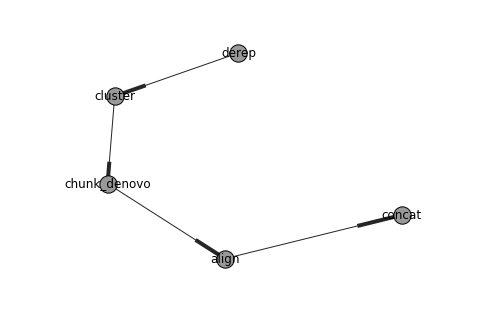

In [208]:
nx.draw(denovo, edge_color='#262626', node_color='#999999', with_labels=True)

In [229]:
jobs = {}
args = {}
results = {}

for node in denovo:
    print node
    jobs[node] = time.sleep
    
for node in denovo:
    args[node] = [np.random.randint(2, 8)]
    

cluster
align
chunk_denovo
concat
derep


In [230]:
ipyclient = ipp.Client()
lbview = ipyclient.load_balanced_view()

In [231]:
for node in nx.topological_sort(denovo):
    ## get list of async results leading to this job
    deps = [results[n] for n in denovo.predecessors(node)]
    # submit and store AsyncResult object
    with lbview.temp_flags(after=deps, block=False):
        results[node] = lbview.apply(jobs[node], *args[node])


In [233]:
results

{'align': <AsyncResult: sleep:finished>,
 'chunk_denovo': <AsyncResult: sleep:finished>,
 'cluster': <AsyncResult: sleep:finished>,
 'concat': <AsyncResult: sleep:finished>,
 'derep': <AsyncResult: sleep:finished>}

In [234]:
## let's try with a threaded view
n_threads = 2
client = ipp.Client()
all_view = client.load_balanced_view() # uses all engines
threaded_view = client.load_balanced_view(targets=client.ids[::n_threads])
threaded_view


<LoadBalancedView [0, 2]>

In [253]:
for node in nx.topological_sort(denovo):
    ## get list of async results leading to this job
    deps = [results[n] for n in denovo.predecessors(node)]
    # submit and store AsyncResult object
    with threaded_view.temp_flags(after=deps, block=False):
        results[node] = threaded_view.apply(jobs[node], *args[node])


In [270]:
results

{'align': <AsyncResult: sleep:finished>,
 'chunk_denovo': <AsyncResult: sleep:finished>,
 'cluster': <AsyncResult: sleep:finished>,
 'concat': <AsyncResult: sleep:finished>,
 'derep': <AsyncResult: sleep:finished>}

In [142]:
seqs

['TGCAGCACCTATGTGTCCGGCACCCCAACGCCTTGGAACTCAGTTAACTGTTCAAGTTGGGCAAGATCAAGTCGTCCCCTTAGCCCCCGCTCCG',
 'TGCAGCACCTATGTGTCCGGCACCCCAACGCCTTGGAACTCAGTTAACTGTTCAAGTTGGGCAAGATCAAGTCGTCCCCTTAGCCCCCGCTCCG',
 'TGCAGCACCTATGTGTCCGGCACCCCAACGCCTTGGAACTCAGTTAACTGTTCAAGTTGGGCAAGATCAAGTCGTCCCCTTAGCCCCCACTCCG']

In [147]:
names = [">"+j+str(i) for i, j in enumerate(names)]
names

['>MT:107-200_REF;+000',
 '>1A_0_0_r1;MT:107-200;size=16;+111',
 '>1A_0_6_r1;MT:107-200;size=1;+222']

In [148]:
string1 = ip.assemble.cluster_within.muscle_call(data, names[:200], seqs[:200])
anames, aseqs = ip.assemble.cluster_within.parsemuscle(data, string1)

In [145]:
for i in range(len(anames)):
    ## filter for max internal indels 
    intind = aseqs[i].rstrip('-').lstrip('-').count('-')
    if intind <= maxindels:
        stack.append("{}\n{}".format(anames[i], aseqs[i]))

NameError: name 'anames' is not defined

In [119]:
io = h5py.File(data.clust_database, 'r')
superseqs = io['seqs']
superints = superseqs[:].view(np.int8)
#np.sum(superints == 45)

In [129]:
import copy
nodashs = superints.copy()
nodashs[nodashs==45] = 78

superints[superints==45] = 78

In [130]:
block = superints[84, :, 5:93]
block

array([[67, 65, 84, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       ..., 
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78],
       [78, 78, 78, ..., 78, 78, 78]], dtype=int8)

In [131]:
import numba

#@numba.jit(nopython=True)
def maxind_numba(block):
    ## remove terminal edges
    inds = 0
    for row in xrange(block.shape[0]):
        where = np.where(block[row] != 45)[0]
        left = np.min(where)
        right = np.max(where)       
        obs = np.sum(block[row, left:right] == 45)
        if obs > inds:
            inds = obs
    return inds

In [132]:
#%%timeit
maxind_numba(block)

0

In [63]:
superseqs.shape
#np.sum(superseqs[:] == "-", axis=2)

ifilter = np.zeros(superints.shape[0], dtype=np.bool_)

for idx in xrange(superseqs.shape[0]):
    block = superints[idx, :, edgearr[idx, 0]:edgearr[idx, 1]]
    sums = np.sum(block == 45, axis=1)
    print(sums)
    if np.max(sums) > 8:
        ifilter[idx] = True
        

NameError: name 'edgearr' is not defined

In [20]:
data.paramsdict["max_Indels_locus"]

(8, 8)

### testing step6

In [59]:
import subprocess
import itertools
import random
import os
import numba
import gzip
import glob
import time
import pty
import datetime
from ipyrad.assemble.util import *
import fcntl

print numba.__version__


0.28.1+0.gfe99fbc.dirty


In [4]:
samples = data.samples.values()
sample = samples[0]

In [55]:
data = ip.load_json("/home/deren/Downloads/pedicularis/newtest2.json")
uhandle = os.path.join(data.dirs.consens, data.name+".utemp.sort")
samples = data.samples.values()

  loading Assembly: newtest2
  from saved path: ~/Downloads/pedicularis/newtest2.json


In [6]:
updf = np.loadtxt(uhandle, dtype="S")

## get samples and names, sorted
samples.sort(key=lambda x: x.name)  
snames = [i.name for i in samples]

## get it
seeds = np.unique(updf[:, 1])
seedsarr = np.column_stack([
                np.arange(len(seeds)),
               [i.rsplit("_", 1)[0] for i in seeds],
               [i.rsplit("_", 1)[1] for i in seeds]])

seedsarr[:, 1] = [snames.index(i) for i in seedsarr[:, 1]]
seedsarr = seedsarr.astype(np.int64)

seedsarr

array([[    0,     0,   100],
       [    1,     0, 10004],
       [    2,     0, 10011],
       ..., 
       [84340,    12,  9984],
       [84341,    12,   999],
       [84342,    12,  9991]])

In [39]:
ipyclient = ipp.Client()
dview = ipyclient[:]
lbview = ipyclient.load_balanced_view()
dview

<DirectView [0, 1, 2, 3]>

In [8]:
#%%timeit -n 1

uarr = np.zeros((updf.shape[0], 3), dtype=np.int64)
idx = -1
lastloc = None
for ldx in xrange(updf.shape[0]):
    tloc = updf[ldx, 1]
    if tloc != lastloc:
        idx += 1
    uarr[ldx, 0] = idx
    lastloc = tloc

In [9]:
uarr

array([[    0,     0,     0],
       [    1,     0,     0],
       [    1,     0,     0],
       ..., 
       [84341,     0,     0],
       [84341,     0,     0],
       [84342,     0,     0]])

In [10]:
## create a column with sample index
uarr[:, 1] = [int(snames.index(i.rsplit("_", 1)[0])) for i in updf[:, 0]]
## create a column with only consens index for sample
uarr[:, 2] = [int(i.rsplit("_", 1)[1]) for i in updf[:, 0]]
uarr = uarr.astype(np.int64)

In [11]:
uarr

array([[     0,     11,  54121],
       [     1,      1,  54767],
       [     1,      2,   7218],
       ..., 
       [ 84341,     10, 162257],
       [ 84341,     11,  12785],
       [ 84342,     11,  58827]])

In [35]:
@numba.jit(nopython=True)
def fill_dups(seedsarr, uarr):
    ## filter for duplicates
    dfilter = np.zeros(seedsarr.shape[0], dtype=np.bool_)
    
    ## fill dfilter
    for idx in xrange(seedsarr.shape[0]):
        ## get idx of seed and matches
        sidxs = uarr[uarr[:, 0] == idx, 1]
        seedx = seedsarr[seedsarr[:, 0] == idx, 1]
        counts = np.concatenate((sidxs, seedx))
        if np.bincount(counts).max() > 1:
            dfilter[idx] = True
    return dfilter

In [16]:
%%timeit -n 1

fill_dups(seedsarr, uarr)

1 loop, best of 3: 2min 17s per loop


In [31]:
(0.0022*84000) / 60.

3.08

In [25]:
%%timeit -n 1 

idx = 83000
sidxs = uarr[uarr[:, 0] == idx, 1]
seedx = seedsarr[seedsarr[:, 0] == idx, 1]
a = np.concatenate([sidxs, seedx])
np.bincount(a).max()


1 loop, best of 3: 2.21 ms per loop


In [12]:
@numba.jit(nopython=True)
def fill_duplicates_serial(seedsarr, uarr, ntax):
    ## filter for duplicates
    dfilter = np.zeros(seedsarr.shape[0], dtype=np.bool_)
    
    ## fill dfilter
    for idx in xrange(seedsarr.shape[0]):
        ## get idx of seed and matches
        sidxs = uarr[uarr[:, 0] == idx, 1]
        seedx = seedsarr[seedsarr[:, 0] == idx, 1]
        
        ## do this b/c joining arrs is hard in numba
        counts = np.zeros(ntax, dtype=np.int64)
        for sidx in sidxs:
            counts[sidx] += 1
        for sidx in seedx:
            counts[sidx] += 1
        if counts.max() > 1:
            dfilter[idx] = True
    return dfilter

In [18]:
@numba.jit(nopython=True)
def fill_duplicates_parallel(base, block, seedsarr, uarr, ntax):
    """ applies filter to block of loci """
    ## filter for duplicates
    size = min(block, seedsarr.shape[0] - (base))
    dfilter = np.zeros(size, dtype=np.bool_)

    ## fill dfilter
    for bidx in xrange(size):
        idx = bidx + base
        ## get idx of seed and matches
        sidxs = uarr[uarr[:, 0] == idx, 1]
        seedx = seedsarr[seedsarr[:, 0] == idx, 1]
        
        ## do this b/c joining arrs is hard in numba
        counts = np.zeros(ntax, dtype=np.int64)
        for sidx in sidxs:
            counts[sidx] += 1
        for sidx in seedx:
            counts[sidx] += 1
        if counts.max() > 1:
            dfilter[bidx] = True
    return dfilter

In [40]:
@numba.jit(nopython=True)
def fill_duplicates_parallel(base, block, seedsarr, uarr, ntax):
    """ applies filter to block of loci """
    ## filter for duplicates
    size = min(block, seedsarr.shape[0] - (base))
    dfilter = np.zeros(size, dtype=np.bool_)

    ## fill dfilter
    for bidx in xrange(size):
        idx = bidx + base
        ## get idx of seed and matches
        sidxs = uarr[uarr[:, 0] == idx, 1]
        seedx = seedsarr[seedsarr[:, 0] == idx, 1]
        bins = np.concatenate((sidxs, seedx))
        counts = np.bincount(bins)
        if counts.max() > 1:
            dfilter[bidx] = True
    return dfilter

In [41]:
seedsarr.shape

blocks = (seedsarr.shape[0] / 4) + (seedsarr.shape[0] % 4)
blocks /= 2
blocks

10544

In [42]:

dupres = {}
for test in xrange(0, seedsarr.shape[0], blocks):
    async = lbview.apply(fill_duplicates_parallel, *(test, blocks, seedsarr, uarr, len(samples)))
    dupres[test] = async
    
ipyclient.wait_interactive()       
keys = sorted(dupres.keys())
dfilter_par = np.concatenate([dupres[key].result() for key in keys])

   8/8 tasks finished after  107 s
done


In [63]:
dfilter_par

array([False, False, False, ..., False, False, False], dtype=bool)

In [20]:
dupres = {}
for test in xrange(0, seedsarr.shape[0], 22000):
    async = lbview.apply(fill_duplicates_parallel, *(test, 22000, seedsarr, uarr, len(samples)))
    dupres[test] = async
    
ipyclient.wait_interactive()       
keys = sorted(dupres.keys())
dfilter_par = np.concatenate([dupres[key].result() for key in keys])

   4/4 tasks finished after  132 s
done


In [64]:
data._ipcluster

{'cluster_id': '',
 'cores': 4,
 'engines': 'Local',
 'profile': 'default',
 'quiet': 0,
 'timeout': 120}

In [50]:
keys = sorted(dupres.keys())
dfilter_par = np.concatenate([dupres[key].result() for key in keys])
dfilter_par

array([False, False, False, ..., False, False, False], dtype=bool)

In [ ]:
ipyclient.wait_interactive()

In [14]:
dupres = {}
for chunk in xrange(0, seedsarr.shape[0], 1000):
    seedchunk = seedsarr[chunk:chunk+1000]
    dupres[chunk] = lbview.apply(fill_duplicates, *(chunk, seedchunk, uarr, len(samples)))

keys = sorted(dupres.keys())
dfilter_par = np.concatenate([dupres[key].get() for key in keys])

KeyboardInterrupt: 

In [52]:
%%timeit -n 1 

dfilter_ser = fill_duplicates_serial(0, seedsarr, uarr, len(samples))

In [55]:
dfilter_ser

array([False, False, False, ..., False, False, False], dtype=bool)

### Insert indels

In [453]:
ocatg[50, :10]
for iloc in xrange(ocatg.shape[0]):
    indidx = np.where(indels[iloc, :])[0]
    if np.any(indidx):
        print iloc, indidx

7 [94]
9 [94]
35 [94]
45 [94]
48 [94]
112 [94]
127 [94]
144 [94]
166 [94]
167 [94]
199 [94]
202 [27]
294 [17]
304 [94]
309 [94 95]
328 [94]
335 [94]
379 [37]
397 [94]
417 [94]
421 [46]
435 [94]
457 [94]
464 [94]
475 [94]
483 [94]
490 [94]
492 [94]
612 [94]
654 [94]
659 [48]
674 [94 95]
679 [94]
706 [94]
719 [94]
726 [94]
730 [94]
815 [48]
820 [94 95]
829 [94]
873 [94]
887 [22 72]
899 [94]
919 [94]
955 [94]
973 [94]
974 [94]
984 [94]


In [557]:
ocatg.shape

(1000, 180, 4)

In [593]:
@numba.jit(nopython=True)
def inserted_indels(indels, ocatg):
    ## return copy with indels inserted
    newcatg = np.zeros(ocatg.shape, dtype=np.uint32)
    
    ## iterate over loci and make extensions for indels   
    for iloc in xrange(ocatg.shape[0]):
        ## get indels indices
        indidx = np.where(indels[iloc, :])[0]
        if np.any(indidx):
            ## which new (empty) rows will be added
            allrows = np.arange(ocatg.shape[1])
            mask = np.ones(allrows.shape[0], dtype=np.bool_)
            for idx in indidx:
                mask[idx] = False
            not_idx = allrows[mask==1]
            
            ## fill in new data into all other spots
            newcatg[iloc][not_idx] = ocatg[iloc, :not_idx.shape[0]]
        else:
            newcatg[iloc] = ocatg[iloc]
    return newcatg


In [583]:
@numba.jit(nopython=True)
def newarr(ocatg):
    return np.arange(ocatg.shape[1])#, dtype=np.int32)

In [613]:
onall.dtype

dtype('uint8')

In [619]:
smpio = os.path.join(data.dirs.consens, sample.name+".tmp.h5")
with h5py.File(smpio, 'r') as smp5:
    print smp5.keys()#.create_dataset('icatg', data=newcatg, dtype=np.uint32)
    print smp5['icatg'][:5]
    print smp5['inall'][:5]

[u'icatg', u'inall']
[[[ 0  0 16  0]
  [ 0  0  0 16]
  [16  0  0  0]
  ..., 
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0 18  0]
  [ 0  0  0 18]
  [18  0  0  0]
  ..., 
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0 18  0]
  [ 0  0  0 18]
  [18  0  0  0]
  ..., 
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0 20  0]
  [ 0  0  0 20]
  [20  0  0  0]
  ..., 
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]

 [[ 0  0 20  0]
  [ 0  0  0 20]
  [20  0  0  0]
  ..., 
  [ 0  0  0  0]
  [ 0  0  0  0]
  [ 0  0  0  0]]]
[1 1 1 1 1]


In [597]:
#%%timeit
newcatg = inserted_indels(indels, ocatg)
#newcatg[887, :]
newcatg[888, :]

array([[ 0,  0, 19,  0],
       [ 0,  0,  0, 19],
       [19,  0,  0,  0],
       [ 0, 19,  0,  0],
       [ 0,  0,  0, 19],
       [ 0, 19,  0,  0],
       [ 0,  0,  0, 19],
       [ 0,  0, 19,  0],
       [19,  0,  0,  0],
       [ 0,  0,  0, 19],
       [19,  0,  0,  0],
       [ 0,  0,  0, 19],
       [ 0,  0, 19,  0],
       [19,  0,  0,  0],
       [19,  0,  0,  0],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0, 19,  0,  0],
       [ 0, 19,  0,  0],
       [ 0, 19,  0,  0],
       [ 0,  0, 19,  0],
       [ 0, 19,  0,  0],
       [ 0,  0,  0, 19],
       [ 0,  0, 19,  0],
       [ 0,  0,  0, 19],
       [ 0, 19,  0,  0],
       [19,  0,  0,  0],
       [19,  0,  0,  0],
       [19,  0,  0,  0],
       [ 0, 19,  0,  0],
       [19,  0,  0,  0],
       [19,  0,  0,  0],
       [ 0, 19,  0,  0],
       [ 0,  0,  0, 19],
       [ 0,  0,  0, 19],
       [ 0,  0, 19,  0],


In [434]:
# TODO: simplify these funcs / subfuncs
def getfill_numba(indidx, tmpcatg):
    """ 
    Fast array filling function for singlecat. 
    Cannot be fully numba compiled, but has a compiled subfunction
    """
    newrows = np.uint32(tmpcatg.shape[0] + indidx.shape[0])
    newfill = np.zeros(shape=(newrows, 4), dtype=np.uint32)
    res = getfill_numba_sub(tmpcatg, indidx, newfill, newrows)
    return res



@numba.jit("u4[:,:](u4[:,:],u4[:],u4[:,:],u4)", nopython=True)
def getfill_numba_sub(tmpcatg, indidx, newfill, newrows):
    """ compiled subfunction of getfill_numba """
    allrows = np.arange(newrows)
    mask = np.ones(shape=newrows, dtype=np.uint32)
    for idx in indidx:
        mask[idx] = 0
    not_idx = allrows[mask == 1]
    newfill[not_idx, :] = tmpcatg
    return tmpcatg


(1000, 180, 4)

In [438]:
ipath = os.path.join(data.dirs.consens, data.name+".indels")
with h5py.File(ipath, 'r') as ih5:
    indels = ih5["indels"][sidx, :, :]



52

In [378]:
data.nloci = 1000
sample
sidx = snames.index(sample.name)
sidx
snames
hits = uarr[uarr[:, 1] == sidx, :]
hits

array([[  0,   6,  94],
       [  1,   6, 108],
       [  2,   6, 915],
       ..., 
       [997,   6, 963],
       [998,   6, 158],
       [999,   6, 979]])

### singlecat

In [379]:
data.chunks = 100
data.nloci = 1000
nloci = data.nloci


In [380]:
data, sample, hits, sidx 

maxlen = data._hackersonly["max_fragment_length"] + 30

## init tmp save array
smpio = os.path.join(data.dirs.consens, sample.name+".tmp.h5")
if os.path.exists(smpio):
    os.remove(smpio)
smp5 = h5py.File(smpio, 'w')
icatg = smp5.create_dataset('icatg', (nloci, maxlen, 4), dtype=np.uint32)
inall = smp5.create_dataset('inall', (nloci,), dtype=np.uint8)


In [381]:
## get catg and nalleles from step5. the shape of catg: (nconsens, maxlen)
old_h5 = h5py.File(sample.files.database, 'r')
catarr = old_h5["catg"][:]
nall = old_h5["nalleles"][:]
chunksize = data.chunks

In [382]:
## local filters to fill while filling catg array
dfilter = np.zeros(nloci, dtype=np.bool)
ifilter = np.zeros(nloci, dtype=np.uint16)


#### fillcat

In [385]:
#hits, chunksize, catarr, nall, icatg, inall, dfilter, maxlen

In [417]:
#hits[:, 0]
seeds.dtype

dtype('int64')

In [546]:
@numba.jit(nopython=True)
def fill_cats_and_alleles(nloci, maxlen, seeds, hits, catarr, nall):
    """ fill catg and nalleles data in locus sorted order """
    ## arrays to fill
    ocatg = np.zeros((nloci, maxlen, 4), dtype=np.uint32)
    onall = np.zeros(nloci, dtype=np.uint8)

    ## fill the locus data where sample was a seed
    for idx in xrange(seeds.shape[0]):
        loc = seeds[idx, 0]
        cidx = seeds[idx, 2]
        
        ## set locus with sample data
        ocatg[loc, :catarr.shape[1]] = catarr[cidx]
        onall[loc] = nall[cidx]
        
    ## fill the locus data where sample is a hit
    for idx in xrange(hits.shape[0]):
        ## get the locus number
        loc = hits[idx, 0]
        cidx = hits[idx, 2]
        
        ## set locus with sample data
        ocatg[loc, :catarr.shape[1]] = catarr[cidx]
        onall[loc] = nall[cidx]
        
    return ocatg, onall

In [547]:
#%%timeit -n 4
ocatg, onall = fill_cats_and_alleles(nloci, maxlen, seeds, hits, catarr[:], nall[:])

In [253]:
uarr[uarr[:, 0] == 0]

array([[  0,   1,  84],
       [  0,   2,  96],
       [  0,   3,  82],
       [  0,   4,  85],
       [  0,   5,  91],
       [  0,   6,  94],
       [  0,   7,  95],
       [  0,   8,  95],
       [  0,   9, 100],
       [  0,  10,  95],
       [  0,  11, 833]])

In [76]:
icatg[0, :catarr.shape[1]] = catarr[94]

In [48]:
step = iloc = 0
ikeys = udic.groups.keys()
for iloc, seed in enumerate(ikeys):
    ipdf = udic.get_group(seed)
    ask = ipdf.where(ipdf[3] == name).dropna()

NameError: name 'udic' is not defined

### MUlti-muscle-align

In [108]:
data.nloci = 1000
## choose chunk optim size
chunks = 100
if data.nloci < 100:
    chunks = data.nloci
if data.nloci > 10000:
    chunks = 500
if data.nloci > 50000:
    chunks = 1000
if data.nloci > 200000:
    chunks = 2000
## Number of elements in hdf5 chunk may not exceed 4GB
## This is probably not actually optimal, to have such
## enormous chunk sizes, could probably explore efficiency
## of smaller chunk sizes on very very large datasets
chunklen = chunks * len(samples) * maxlen * 4
if chunklen > 4000000000:
    chunks = int(round(4000000000/(len(samples) * maxlen * 4)))

data.chunks = chunks

print data.chunks

100


In [135]:
%%timeit -n 1
updf.loc[:, 3] = np.zeros(updf.shape[0], dtype=np.int64)
idx = -1
lastloc = None
for ldx in xrange(updf.shape[0]):
    tloc = updf.loc[ldx, 1]
    if tloc != lastloc:
        idx += 1
    updf.loc[ldx, 3] = idx
    lastloc = tloc

1 loop, best of 3: 6.12 s per loop


In [139]:
%%timeit -n 1

tmp = np.zeros(updf.shape[0], dtype=np.int64)
idx = -1
lastloc = None
for ldx in xrange(tmp.shape[0]):
    tloc = updf.loc[ldx, 1]
    if tloc != lastloc:
        idx += 1
    tmp[ldx] = idx
    lastloc = tloc
    
updf.loc[:, 3] = tmp

1 loop, best of 3: 2.18 s per loop


In [148]:
uarr = np.zeros((updf.shape[0], 3), dtype=np.int64)
idx = -1
lastloc = None
for ldx in xrange(updf.shape[0]):
    tloc = updf.loc[ldx, 1]
    if tloc != lastloc:
        idx += 1
    uarr[ldx, 0] = idx
    lastloc = tloc

uarr[:, 1] = [names.index(i.rsplit("_", 1)[0]) for i in updf[0]]
## create a column with only consens index
uarr[:, 2] = [int(i.rsplit("_", 1)[1]) for i in updf[0]]


In [153]:
uarr[uarr[:, 1] == 1]


array([[  0,   1,  84],
       [  1,   1,  97],
       [  2,   1, 125],
       ..., 
       [997,   1,  57],
       [998,   1, 146],
       [999,   1,  94]])

In [129]:
uhandle = os.path.join(data.dirs.consens, data.name+".utemp.sort")    
updf = pd.read_table(uhandle, header=None)
names = sorted(data.samples.keys())
## add data.samples index 
updf.loc[:, 3] = [names.index(i.rsplit("_", 1)[0]) for i in updf[0]]
## create a column with only consens index
updf.loc[:, 4] = [i.rsplit("_", 1)[1] for i in updf[0]]
locidx = []
ldx = -1
lastloc = None
for loc in updf.loc[:, 1]:
    if loc != lastloc:
        ldx += 1
    locidx.append(ldx)
    lastloc = loc
    
updf.loc[:, 5] = locidx

udic = updf.groupby(by=1, sort=True)
## get number of clusters
nloci = sum(1 for _ in udic.groups.iterkeys())
updf

,0,1,2,3,4,5
0,1B_0_84,1A_0_100,+,1,84,0
1,1C_0_96,1A_0_100,+,2,96,0
2,1D_0_82,1A_0_100,+,3,82,0
3,2E_0_85,1A_0_100,+,4,85,0
4,2F_0_91,1A_0_100,+,5,91,0
5,2G_0_94,1A_0_100,+,6,94,0
6,2H_0_95,1A_0_100,+,7,95,0
7,3I_0_95,1A_0_100,+,8,95,0
8,3J_0_100,1A_0_100,+,9,100,0
9,3K_0_95,1A_0_100,+,10,95,0


In [110]:
maxlen = data._hackersonly["max_fragment_length"] + 30
smpio = os.path.join(data.dirs.consens, sample.name+".tmp.h5")
if os.path.exists(smpio):
    os.remove(smpio)
smp5 = h5py.File(smpio, 'w')
icatg = smp5.create_dataset('icatg', (nloci, maxlen, 4), dtype=np.uint32)
inall = smp5.create_dataset('inall', (nloci,), dtype=np.uint8)


In [111]:
## get catg and nalleles from step5. the shape of catg: (nconsens, maxlen)
old_h5 = h5py.File(sample.files.database, 'r')
catarr = old_h5["catg"][:]
nall = old_h5["nalleles"][:]
chunksize = data.chunks

In [112]:
## local filters to fill while filling catg array
dfilter = np.zeros(nloci, dtype=np.bool)
ifilter = np.zeros(nloci, dtype=np.uint16)
ikeys = udic.groups.keys()

In [114]:
#%%timeit -n 1

dfilter = ip.assemble.cluster_across.fillcats(sample.name, udic, chunksize, 
                   catarr, nall, icatg, inall, dfilter, maxlen)


In [ ]:
io5 = h5py.File("/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli.indels")
io5['indels'].shape
c = da.from_array(io5['indels'], chunks=(1, 100, 180))

In [84]:
%timeit np.sum(io5["indels"][:] + io5["indels"][:])

100 loops, best of 3: 4.56 ms per loop


In [83]:
%timeit (c + c).sum().compute()

10 loops, best of 3: 264 ms per loop


In [8]:
clustbits = glob.glob("/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/*")
chunk = clustbits[0]
chunk

'/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_1000'

In [9]:
samples.sort(key=lambda x: x.name)
snames = [sample.name for sample in samples]
snames

['1A_0',
 '1B_0',
 '1C_0',
 '1D_0',
 '2E_0',
 '2F_0',
 '2G_0',
 '2H_0',
 '3I_0',
 '3J_0',
 '3K_0',
 '3L_0']

In [10]:
infile = open(chunk, 'rb')
clusts = infile.read().split("//\n//\n")[:-1]
out = []


In [30]:
maxlen = data._hackersonly["max_fragment_length"] + 30
indels = np.zeros((len(samples), len(clusts), maxlen), dtype=np.bool)


In [32]:
loc = 0
clust = clusts[0]
stack = []
lines = clust.strip().split("\n")
names = lines[::2]  
seqs = lines[1::2]  

names = [">{};*{}".format(j[1:], i) for i, j in enumerate(names)]
string1 = ip.assemble.cluster_within.muscle_call(data, names, seqs)
anames, aseqs = ip.assemble.cluster_within.parsemuscle(data, string1)
aseqs = np.array([list(i) for i in aseqs])
thislen = min(maxlen, aseqs.shape[1])

for idx in xrange(aseqs.shape[0]):
    newn = anames[idx].rsplit(';', 1)[0]
    stack.append("{}\n{}".format(newn, aseqs[idx].tostring()))
    sidx = snames.index(anames[idx].rsplit("_", 1)[0])
    indels[sidx, loc, :thislen] = aseqs[idx] == "-"


In [36]:
print "\n".join(stack)

3K_0_776
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGTGCCTAGGTACTACCAAAATCGGC
1A_0_780
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
1B_0_757
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
1C_0_762
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
1D_0_743
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAACAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
2E_0_753
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
2F_0_906
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
2G_0_761
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
2H_0_881
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAGCTCCGACGGGTCACGCGCCTAGGTACTACCAAAATCGGC
3I_0_756
TGCAGCGCACAGGAGGCTCGGTCTTAAGCAGACCCAAGCCTGCAAGAAATTATAG

In [41]:
ipyclient = ipp.Client()
async = ipyclient[0].apply(time.sleep, 1)


In [45]:
async.error

In [70]:
indeltups = glob.glob("/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/*.h5")
indeltups.sort(key=lambda x: int(x.rsplit("_", 1)[-1][:-3]))
indeltups    


['/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_0.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_100.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_200.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_300.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_400.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_500.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_600.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_700.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_800.h5',
 '/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_1000.h5']

In [72]:

## get dims for full indel array
maxlen = data._hackersonly["max_fragment_length"] + 30
#LOGGER.info("maxlen inside build is %s", maxlen)
data.nloci = 1000

## INIT INDEL ARRAY
## build an indel array for ALL loci in cat.clust.gz, 
## chunked so that individual samples can be pulled out
chunksize = 1000
if data.nloci < 1000:
    chunksize = data.nloci
ipath = os.path.join(data.dirs.consens, data.name+".indels")
io5 = h5py.File(ipath, 'w')

In [73]:
iset = io5.create_dataset("indels", 
                         (len(samples), data.nloci, maxlen),
                          dtype=np.bool,
                          chunks=(len(samples), chunksize, maxlen),
                          compression="gzip")

In [86]:
samples.sort()

for tup in indeltups:
    #LOGGER.info('indeltups: %s, %s', tup[0], tup[1])
    start = int(tup.rsplit("_", 1)[-1][:-3])
    with h5py.File(tup, 'r') as ioinds:
        #print(ioinds['indels'][:])
        iset[:, start:start+tup[1], :] += ioinds['indels'][:]

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [55]:
chunk = "/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_100"
with open(chunk, 'rb') as infile:
    clusts = infile.read().split("//\n//\n")[:-1]

In [56]:
samples.sort(key=lambda x: x.name)
snames = [sample.name for sample in samples]

try:
    ## data are already chunked, read in the whole thing
    infile = open(chunk, 'rb')
    clusts = infile.read().split("//\n//\n")[:-1]
    out = []

    ## tmparray to store indel information 
    maxlen = data._hackersonly["max_fragment_length"] + 30
    indels = np.zeros((len(samples), len(clusts), maxlen), dtype=np.bool)

    ## iterate over clusters and align
    loc = 0
    for loc, clust in enumerate(clusts):
        stack = []
        lines = clust.strip().split("\n")
        names = lines[::2]#[i.split()[0][1:] for i in lines]
        seqs = lines[1::2]#[i.split()[1] for i in lines]

        LOGGER.info("seqs first %s %s", len(seqs), seqs)

        ## append counter to end of names b/c muscle doesn't retain order
        names = [">{};*{}".format(j[1:], str(i)) for i, j in enumerate(names)]

        ## don't bother aligning singletons
        if len(names) <= 1:
            if names:
                stack = [names[0]+"\n"+seqs[0]]
        else:
            ## split seqs before align if PE. If 'nnnn' not found (single end 
            ## or merged reads) then `except` will pass it to SE alignment. 
            paired = 1
            try:
                seqs1 = [i.split("nnnn")[0] for i in seqs] 
                seqs2 = [i.split("nnnn")[1] for i in seqs]
            except IndexError:
                paired = 0

            if paired:
                string1 = ip.assemble.cluster_within.muscle_call(data, names, seqs1)
                string2 = ip.assemble.cluster_within.muscle_call(data, names, seqs2)
                anames, aseqs1 = ip.assemble.cluster_within.parsemuscle(data, string1)
                anames, aseqs2 = ip.assemble.cluster_within.parsemuscle(data, string2)

                ## resort so they're in same order
                aseqs = [i+"nnnn"+j for i, j in zip(aseqs1, aseqs2)]
                for i in xrange(len(anames)):
                    stack.append(anames[i].rsplit(';', 1)[0]+"\n"+aseqs[i])
                    sidx = [snames.index(anames[i].rsplit("_", 1)[0])]
                    ## store the indels and separator regions as indels
                    locinds = np.zeros(maxlen, dtype=np.bool)
                    for idx in range(min(maxlen, len(aseqs[i]))):
                        if aseqs[i][idx] == "-":
                            locinds[idx] = True
                    indels[sidx, loc, :] = locinds

            else:
                string1 = ip.assemble.cluster_within.muscle_call(data, names, seqs)
                #print names, seqs, string1
                anames, aseqs = ip.assemble.cluster_within.parsemuscle(data, string1)
                aseqs = np.array([list(i) for i in aseqs])
                thislen = min(maxlen, aseqs.shape[1])
                for i in xrange(aseqs.shape[0]):
                    newn = anames[i].rsplit(';', 1)[0]
                    ## save to aligned cluster
                    stack.append("{}\n{}".format(newn, aseqs[i].tostring()))
                    ## name index from sorted list (indels order)
                    sidx = snames.index(anames[i].rsplit("_", 1)[0])
                    ## store the indels
                    #locinds = np.zeros(maxlen, dtype=np.bool)
                    indels[sidx, loc, :thislen] = aseqs[i] == "-"
                    # for idx in range(thislen):
                    #     if aseqs[i][idx] == "-":
                    #         locinds[idx] = True
                    # indels[sidx, loc, :] = locinds
                    
except Exception:
    raise

In [58]:
indels.sum()

68

In [7]:
## ensure sorted order
samples.sort(key=lambda x: x.name)
snames = [sample.name for sample in samples]

out = []

## tmparray to store indel information 
maxlen = data._hackersonly["max_fragment_length"] + 30
indels = np.zeros((len(samples), len(clusts), maxlen), dtype=np.bool)


In [8]:
## iterate over clusters and align
loc = 0
for loc, clust in enumerate(clusts):
    stack = []
    lines = clust.strip().split("\n")
    names = lines[::2]
    seqs = lines[1::2]


In [9]:
names = [j+";*"+str(i) for i, j in enumerate(names)]
names

['>1C_0_476;*0',
 '>1A_0_490;*1',
 '>1B_0_466;*2',
 '>1D_0_468;*3',
 '>2E_0_470;*4',
 '>2F_0_498;*5',
 '>2G_0_480;*6',
 '>2H_0_477;*7',
 '>3I_0_472;*8',
 '>3J_0_497;*9',
 '>3K_0_495;*10',
 '>3L_0_478;*11']

In [10]:
string1 = ip.assemble.cluster_within.muscle_call(data, names, seqs)
anames, aseqs = ip.assemble.cluster_within.parsemuscle(data, string1)
anames

('1C_0_476;*0',
 '1A_0_490;*1',
 '1B_0_466;*2',
 '1D_0_468;*3',
 '2E_0_470;*4',
 '2F_0_498;*5',
 '2G_0_480;*6',
 '2H_0_477;*7',
 '3I_0_472;*8',
 '3J_0_497;*9',
 '3K_0_495;*10',
 '3L_0_478;*11')

In [11]:
for i in xrange(len(anames)):
    stack.append("{}\n{}".format(anames[i].rsplit(';', 1)[0], aseqs[i]))
    sidx = snames.index(anames[i].rsplit("_", 1)[0])
    ## store the indels
    locinds = np.zeros(maxlen, dtype=np.bool)
    for idx in range(min(maxlen, len(aseqs[i]))):
        if aseqs[i][idx] == "-":
            locinds[idx] = True
    indels[sidx, loc, :] = locinds

In [39]:
anames

('1C_0_476;*0',
 '1A_0_490;*1',
 '1B_0_466;*2',
 '1D_0_468;*3',
 '2E_0_470;*4',
 '2F_0_498;*5',
 '2G_0_480;*6',
 '2H_0_477;*7',
 '3I_0_472;*8',
 '3J_0_497;*9',
 '3K_0_495;*10',
 '3L_0_478;*11')

In [85]:
%%timeit -n 3
for clust in clusts:
    proc1 = subprocess.Popen([ip.bins.muscle, "-quiet"],
                          stdin=subprocess.PIPE,
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE)
    proc1.communicate(clust)

KeyboardInterrupt: 

In [49]:
%%timeit -n 3

procs = []
for clust in clusts:
    proc = subprocess.Popen([ip.bins.muscle, "-quiet"],
                              stdin=subprocess.PIPE,
                              stderr=subprocess.PIPE,
                              stdout=subprocess.PIPE)
    proc.stdin.write(clust)
    procs.append(proc)
    
res = [i.communicate()[0] for i in procs]

3 loops, best of 3: 1.74 s per loop


In [35]:
#%%timeit -n 1

proc1 = subprocess.Popen([ip.bins.muscle],
                          stdin=subprocess.PIPE,
                          stderr=subprocess.PIPE,
                          stdout=subprocess.PIPE, 
                          universal_newlines=True)


fcntl.fcntl(proc1.stdout.fileno(), fcntl.F_SETFL, os.O_NONBLOCK)
fcntl.fcntl(proc1.stderr.fileno(), fcntl.F_SETFL, os.O_NONBLOCK)
fcntl.fcntl(proc1.stdin.fileno(), fcntl.F_SETFL, os.O_NONBLOCK)

0

In [42]:
proc1.stdin.write(clusts[0]+"\n")

In [43]:
#proc1.stdin.write(aaa+"\n")
#proc1.stdout.flush()
#proc1.stdin.close()"
proc1.stdin.flush()#read()

In [44]:
proc1.stdout.read()

IOError: [Errno 11] Resource temporarily unavailable

In [646]:
rr = ""
#try:
proc1.stdout.readline()
#except IOError:
#    pass
#    print(rr)
    

IOError: [Errno 11] Resource temporarily unavailable

In [631]:
proc1 = subprocess.Popen([ip.bins.muscle, "-quiet"],
                      bufsize=0,
                      stdin=subprocess.PIPE,
                      stderr=subprocess.STDOUT,
                      stdout=subprocess.PIPE)

In [596]:
SECONDS_TO_WAIT = 2
select.select([proc1.stdout], 
              [], 
              [proc1.stdout, proc1.stderr],
              SECONDS_TO_WAIT)

TypeError: argument must be an int, or have a fileno() method.

In [575]:
proc1.stdout.read()


'>1C_0_392_2\nTGCAGTTCGRATGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACGAGCACTC\nGAACCATTCCYGGATATTGCATATATGAGTGCCA\n>2E_0_410_4\nTGCAGTTCGAAAGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACCAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>2F_0_916_5\nTGCAGTTCGAAAGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACCAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>2G_0_414_6\nTGCAGTTCGAAAGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACCAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>2H_0_391_7\nTGCAGTTCGAATGGTATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACGAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>1B_0_388_0\nTGCAGTTCGGATGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACGAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>1A_0_416_1\nTGCAGTTCGGATGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACGAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>1D_0_397_3\nTGCAGTTCGAATGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTCACCCACGAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGTGCCA\n>3I_0_771_8\nTGCAGTTCGAATGGAATGTTGTCTCAAGAAGCTGGTTGTCTCGTTGACCCACGAGCACTC\nGAACCATTCCTGGATATTGCATATATGAGGGCCA\n

In [302]:
select.select([proc1.stdout], [], [], 0)

([], [], [])

In [324]:
proc1.stdout.readline()

KeyboardInterrupt: 

In [506]:
#%%prun

chunk = "/home/deren/Documents/ipyrad/tests/cli/cli_consens/cli-tmpaligns/cli.chunk_100"

with open(chunk, 'rb') as infile:
    clusts = infile.read().split("//\n//\n")[:-1]

In [246]:
## storage and a counter for discarded clusters due to poor alignment
out = []
highindels = 0

## iterate over clusters and align
for clust in clusts:
    stack = []
    lines = clust.split("\n")
    names = lines[::2]
    seqs = lines[1::2]
    badalign = 0
    
    names = ["{}_{}".format(j, i) for i, j in enumerate(names)]
    if not seqs:
        print(string1[-2])
    
    inputstr = "\n".join(["{}\n{}".format(i, j) for i, j in zip(names, seqs)])
    #string1 = proc1.communicate(inputstr)[0]
    #print inputstr
    #print clust
    string1 = muscle_call(data, names[:200], seqs[:200])
    #out.append(string1)

#print len(stack)

In [245]:
string1 = muscle_call(data, names[:200], seqs[:200])

In [242]:
def muscle_call(data, names, seqs):
    """ 
    Makes subprocess call to muscle. A little faster than before. 
    TODO: Need to make sure this works on super large strings and does not 
    overload the PIPE buffer.
    """

    ## make input string
    inputstr = "\n".join([">{}\n{}".format(i, j) for i, j in zip(names, seqs)])
    args = [ip.bins.muscle, "-quiet"]

    ## increase gap penalty if reference region is included 
    ## This could use more testing/refining!
    if "_REF;+0" in names:
        args += ["-gapopen", "-1200"]

    ## make a call arg
    proc1 = subprocess.Popen(args,
                             stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE)
    ## return result
    return proc1.communicate(inputstr)[0]

### derep

In [64]:
usort = open("./pairgbstest/pairgbstest_consens/pairgbstest.utemp.sort")
cmd1 = ["cut", "-f", "2"]
cmd2 = ["uniq"]
cmd3 = ["wc"]
proc1 = subprocess.Popen(cmd1, stdin=usort, stdout=subprocess.PIPE)
proc2 = subprocess.Popen(cmd2, stdin=proc1.stdout, stdout=subprocess.PIPE)
proc3 = subprocess.Popen(cmd3, stdin=proc2.stdout, stdout=subprocess.PIPE)
nseeds = int(proc3.communicate()[0].split()[0])
proc1.stdout.close()
proc2.stdout.close()
proc3.stdout.close()

nseeds
2000000 / 20000

100

In [65]:
"{}{}".format(0, 10)

'010'

In [13]:
infile = sample.files.
print infile
outfile = os.path.join(data.dirs.edits, sample.name+"_derep.fastq")

strand = "plus"
if "gbs" in data.paramsdict["datatype"]:
    strand = "both"    

## do dereplication with vsearch
cmd = [ipyrad.bins.vsearch,
       "-derep_fulllength", infile, 
       "-strand", strand,
       "-output", outfile,
       "-threads", str(1),
       "-fasta_width", str(0),
       "-sizeout"]

#LOGGER.info(cmd)

## run vsearch
proc = subprocess.Popen(cmd)#, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
msg = proc.communicate()[0]
print msg, proc.returncode
if proc.returncode:
    raise IPyradWarningExit(msg)

    #except subprocess.CalledProcessError as inst:
#    print inst
    #LOGGER.error(inst)
#    raise IPyradError(inst)

('/home/deren/Documents/ipyrad/tests/pairgbstest/pairgbstest_fastqs/2G_0_R1_.fastq.gz', '/home/deren/Documents/ipyrad/tests/pairgbstest/pairgbstest_fastqs/2G_0_R2_.fastq.gz')


TypeError: execv() arg 2 must contain only strings

### clustern

In [6]:
data.dirs.clusts = os.path.join(
            os.path.realpath(data.paramsdict["project_dir"]),
            data.name+"_"+"clust_"+str(data.paramsdict["clust_threshold"]))
if not os.path.exists(data.dirs.clusts):
    os.makedirs(data.dirs.clusts)

In [7]:
## get the dereplicated reads 
if "reference" in data.paramsdict["assembly_method"]:
    derephandle = os.path.join(data.dirs.edits, sample.name+"-refmap_derep.fastq")
else:
    derephandle = os.path.join(data.dirs.edits, sample.name+"_derep.fastq")

## create handles for the outfiles
uhandle = os.path.join(data.dirs.clusts, sample.name+".utemp")
temphandle = os.path.join(data.dirs.clusts, sample.name+".htemp")

In [8]:
if data.paramsdict["datatype"] == "gbs":
    reverse = " -strand both "
    cov = " -query_cov .33 " 
    minsl = " 0.33"
elif data.paramsdict["datatype"] == 'pairgbs':
    reverse = "  -strand both "
    cov = " -query_cov .75 " 
    minsl = " 0.75"  
else:  ## rad, ddrad
    reverse = " -leftjust "
    cov = " -query_cov .90 "
    minsl = " 0.5"

In [9]:
## If this value is not null (which is the default) then optionally
## override query cov
if data._hackersonly["query_cov"]:
    cov = " -query_cov "+str(data._hackersonly["query_cov"])
    assert data._hackersonly["query_cov"] <= 1, "query_cov must be <= 1.0"


In [10]:
nthreads = 4

## get call string
cmd = ipyrad.bins.vsearch+\
    " -cluster_smallmem "+derephandle+\
    reverse+\
    cov+\
    " -id "+str(data.paramsdict["clust_threshold"])+\
    " -userout "+uhandle+\
    " -userfields query+target+id+gaps+qstrand+qcov"+\
    " -maxaccepts 1"+\
    " -maxrejects 0"+\
    " -minsl "+str(minsl)+\
    " -fulldp"+\
    " -threads "+str(nthreads)+\
    " -usersort "+\
    " -notmatched "+temphandle+\
    " -fasta_width 0"

In [11]:
subprocess.call(cmd, shell=True,
                     stderr=subprocess.STDOUT,
                     stdout=subprocess.PIPE)

0

### build clusters

In [12]:
derepfile = os.path.join(data.dirs.edits, sample.name+"_derep.fastq")

## vsearch results files
uhandle = os.path.join(data.dirs.clusts, sample.name+".utemp")
hhandle = os.path.join(data.dirs.clusts, sample.name+".htemp")


In [13]:
import gzip
import pandas as pd

sample.files.clusters = os.path.join(data.dirs.clusts,
                                     sample.name+".clust.gz")


In [14]:
usort = os.path.join(data.dirs.clusts, sample.name+".utemp.sort")

cmd = ["sort", "-k", "2", uhandle, "-o", usort]
proc = subprocess.Popen(cmd)
_ = proc.communicate()[0]

In [15]:
data.dirs.clusts

'/home/deren/Documents/ipyrad/tests/cli/cli_clust_0.85'

In [17]:
sample.files.clusters = os.path.join(data.dirs.clusts, sample.name+".clust.gz")
clustsout = gzip.open(sample.files.clusters, 'wb')
maxindels = 6

alldereps = {}
with open(derepfile, 'rb') as ioderep:
    dereps = itertools.izip(*[iter(ioderep)]*2)
    for namestr, seq in dereps:
        nnn, sss = [i.strip() for i in namestr, seq]
        alldereps[nnn[1:]] = sss

## store observed seeds (this could count up to >million in bad data sets)
seedsseen = set()

## Iterate through the usort file grabbing matches to build clusters
with open(usort, 'rb') as insort:
    ## iterator, seed null, seqlist null
    isort = iter(insort)
    lastseed = 0
    fseqs = []
    seqlist = []
    seqsize = 0
    while 1:
        ## grab the next line
        try:
            hit, seed, _, ind, ori, _ = isort.next().strip().split()
        except StopIteration:
            break

        ## same seed, append match
        if seed != lastseed:
            seedsseen.add(seed)
            ## store the last fseq, count it, and clear fseq
            if fseqs:
                seqlist.append("\n".join(fseqs))
                seqsize += 1
                fseqs = []

            ## occasionally write to file
            if not seqsize % 10000:
                if seqlist:
                    clustsout.write("\n//\n//\n".join(seqlist)+"\n//\n//\n")
                    ## reset list and counter
                    seqlist = []

            ## store the new seed on top of fseq
            fseqs.append(">{}*\n{}".format(seed, alldereps[seed]))
            lastseed = seed

        ## add match to the seed
        seq = alldereps[hit]
        ## revcomp if orientation is reversed
        if ori == "-":
            seq = revcomp(seq)
        ## only save if not too many indels
        if int(ind) <= maxindels:                
            fseqs.append(">{}{}\n{}".format(hit, ori, seq))
        else:
            LOGGER.info("filtered by maxindels: %s %s", ind, seq)

## write whatever is left over to the clusts file
if fseqs:
    seqlist.append("\n".join(fseqs))
if seqlist:
    clustsout.write("\n//\n//\n".join(seqlist)+"\n//\n//\n")

## now write the seeds that had no hits. Make dict from htemp
with open(hhandle, 'rb') as iotemp:
    nohits = itertools.izip(*[iter(iotemp)]*2)
    seqlist = []
    seqsize = 0
    while 1:
        try:
            nnn, sss = [i.strip() for i in nohits.next()]
        except StopIteration:
            break

        ## occasionally write to file
        if not seqsize % 10000:
            if seqlist:
                clustsout.write("\n//\n//\n".join(seqlist)+"\n//\n//\n")
                ## reset list and counter
                seqlist = []

        ## append to list if new seed
        if nnn[1:] not in seedsseen:
            seqlist.append("{}*\n{}".format(nnn, sss))
            seqsize += 1            

## write whatever is left over to the clusts file
if seqlist:
    clustsout.write("\n//\n//\n".join(seqlist)+"\n//\n//\n")

## close the file handle
clustsout.close()
del alldereps

In [33]:
tmpdir = os.path.join(os.path.realpath(data.dirs.project), 
                      data.name+'-tmpalign')
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)

In [34]:
## get the number of clusters
clustfile = os.path.join(data.dirs.clusts, sample.name+".clust.gz")
with gzip.open(clustfile, 'rb') as clustio:
    tclust = clustio.read().count("//")//2
    optim = (tclust//10) + (tclust%10)
optim

100

In [35]:
## write optim clusters to each tmp file
clustio = gzip.open(clustfile, 'rb')
inclusts = iter(clustio.read().strip().split("//\n//\n"))
grabchunk = list(itertools.islice(inclusts, optim))

idx = 0
while grabchunk:
    tmpfile = os.path.join(tmpdir, sample.name+"_chunk_{}.ali".format(idx)) 
    with open(tmpfile, 'wb') as out:
        out.write("//\n//\n".join(grabchunk))
    idx += 1
    grabchunk = list(itertools.islice(inclusts, optim))
clustio.close()

In [66]:
chunk = "cli/cli-tmpalign/1B_0_chunk_0.ali"

infile = open(chunk, 'rb')
    
clusts = infile.read().split("//\n//\n")
out = []

if not clusts[0]:
    print 'hi'

In [132]:
np.array(anames)
#np.all(ass == "-", axis=1)
list(ass[0])

['T',
 'G',
 'C',
 'A',
 'G',
 'G',
 'C',
 'T',
 'T',
 'C',
 'T',
 'T',
 'A',
 'G',
 'G',
 'T',
 'T',
 'A',
 'A',
 'T',
 'C',
 'C',
 'A',
 'C',
 'T',
 'G',
 'C',
 'C',
 'T',
 'T',
 'A',
 'C',
 'A',
 'T',
 'A',
 'G',
 'A',
 'T',
 'A',
 'C',
 'A',
 'A',
 'A',
 'T',
 'C',
 'G',
 'C',
 'A',
 'C',
 'G',
 'A',
 'G',
 'G',
 'T',
 'A',
 'T',
 'G',
 'A',
 'G',
 'A',
 'C',
 'T',
 'G',
 'T',
 'T',
 'A',
 'T',
 'C',
 'C',
 'A',
 'T',
 'C',
 'A',
 'A',
 'G',
 'C',
 'A',
 'A',
 'T',
 'C',
 'G',
 'T',
 'A',
 'A',
 'G',
 'A',
 'G',
 'G',
 'T',
 'T',
 'C',
 'C',
 'A',
 'G']

In [122]:
revs = np.array([i.split(";")[-1][0] == "+" for i in anames])
[np.where(i != "-")[0].max() for i in ass[revs, :]]
#np.array([list(aseqs[i]) for i in range(aseqs.shape[0]) if anames[i].])

AttributeError: 'list' object has no attribute 'min'

In [133]:
def parsemuscle(data, out):
    """ 
    parse muscle string output into two sorted lists. Sorts them first.
    """
    ## remove '>' and split lines
    lines = out[1:].split("\n>")
    ## grab the names
    names = [line.split("\n", 1)[0] for line in lines]
    ## grab the seqs
    seqs = [line.split("\n", 1)[1].replace("\n", "") for line in lines]
    tups = zip(names, seqs)
    ## who knew, zip(*) is the inverse of zip
    anames, aseqs = zip(*sorted(tups, 
                        key=lambda x: int(x[0].split(";")[-1][1:])))
    ## remove reference if present
    if "_REF;+0" in anames[0]:
        return anames[1:], aseqs[1:]
    else:
        return anames, aseqs


In [142]:
[i.tostring() for i in ass]

['TGCAGGCTTCTTAGGTTAATCCACTGCCTTACATAGATACAAATCGCACGAGGTATGAGACTGTTATCCATCAAGCAATCGTAAGAGGTTCCAG',
 'TGCAGGCTTCTTAGGTTAATCCACTGCGTTACATAGATACAAATCGCACGAGGTATGAGACTGTTATCCATCAAGCAATCGTAAGATGTTCCAG',
 'TGCAGGCTTCTTAGGTTAATCCACTGCGTTACATAGATACAAATCGCACGAGGTATGAGACTGTTATCCATCAAGCAATCGTAAGAGGTTCCAG']

In [78]:
## a counter for discarded clusters due to poor alignment
highindels = 0

## iterate over clusters and align
for clust in clusts:
    stack = []
    lines = clust.split("\n")
    names = lines[::2]
    seqs = lines[1::2]
    badalign = 0

    ## append counter to end of names b/c muscle doesn't retain order
    names = [nam+str(idx) for idx, nam in enumerate(names)]
    if len(seqs) == 1:
        print names, seqs
        stack = ["{}\n{}".format(names[0], seqs[0])]
    else:
        string1 = ip.assemble.cluster_within.muscle_call(data, names[:200], seqs[:200])
        anames, aseqs = ip.assemble.cluster_within.parsemuscle(data, string1)
        print string1
        
        

>>1B_0_10028_r1;size=23;*0
TGCAGAAAGGCCAGGGTTAGCCCGGATTAGAAGCTTCAAGTGGTGATATCCTCCGGTCCT
AATTAAGTTAAGCTTTTCGTAGAATAGACGTTTT
>>1B_0_10036_r1;size=1;+1
TGCAGAAAGGCCAGGGTTAGCCCGGATTAGAAGCTTCAAGTGGTGATATCCTCCGGTCCT
AATTAAGTTAAGCTTTTCGTAGCATAGACGTTTT

>>1B_0_10073_r1;size=16;*0
TGCAGTGTTGTTAGTTGCGTCTGAGCCGGTCCATATAAGAGGAGTTCATAGTTCTACACC
GCCATGGTAATTGGCCGTAGCAGTATAAAGGTGT
>>1B_0_10072_r1;size=1;+1
TGCAGTGTTGTTAGTTGCGTCTGAGCCGGTCCATATAAGAGGAGTTCATACTTCTACACC
GCCATGGTAATTGGCCGTAGCAGTATAAAGGTGT

>>1B_0_1007_r1;size=15;*0
TGCAGTGGTCTGTGCTTGGGTGAGACAGGTCGGATGGGTATTTATTCAGAGTGGCCGATC
TGCTTGCAATGCTAGCCCGACAACGTATTCAGAC
>>1B_0_1006_r1;size=1;+1
TGCAGTGGTCTGTGCTTGGGTGAGACAGGTCGGATGGGTATTTATTCAGAGTGGTCGATC
TGCTTGCAATGCTAGCCCGACAACGTATTCAGAC

>>1B_0_10089_r1;size=19;*0
TGCAGCTATAGATTCATAACCGCAATATGAGCGAAGTGCCGCTAGGACAGAGCCACTAAC
CGCACAGACTTGTACAGTACGATGCCATGTAATG
>>1B_0_10104_r1;size=1;+1
TGCAGCTATAGATTCATCACCGCAATATGAGCGAAGTGCCGCTAGGACAGAGCCACTAAC
CGCACAGACTTGTACAGTACGATGCCATGTAATG

>>1B_0_10109_r1;si

### Cluster across 

In [4]:
samples = [sample1, sample2, sample3]
randomseed = 43245

conshandles = [os.path.join(data.dirs.consens, sample.name+".consens.gz") \
               for sample in samples if \
               sample.stats.reads_consens]

## concatenat gzip files
cmd = ['cat'] + conshandles
allcons = os.path.join(data.dirs.consens, data.name+"_catcons.tmp")
#LOGGER.debug(" ".join(cmd))
with open(allcons, 'w') as output:
    call = subprocess.Popen(cmd, stdout=output)
    call.communicate()

subs = ["/>/!s/W/A/g", "/>/!s/w/A/g", "/>/!s/R/A/g", "/>/!s/r/A/g", 
        "/>/!s/M/A/g", "/>/!s/m/A/g", "/>/!s/K/T/g", "/>/!s/k/T/g", 
        "/>/!s/S/C/g", "/>/!s/s/C/g", "/>/!s/Y/C/g", "/>/!s/y/C/g"]
subs = ";".join(subs)


cmd1 = ["gunzip", "-c", allcons]
cmd2 = ["sed", subs]
#LOGGER.debug(" ".join(cmd1))
#proc1 = subprocess.Popen(cmd1, stdout=subprocess.PIPE)
#proc2 = subprocess.Popen(cmd2, stdin=proc1.stdout, stdout=subprocess.PIPE)
proc1 = subprocess.Popen(cmd1, stdout=subprocess.PIPE)
allhaps = allcons.replace("_catcons.tmp", "_cathaps.tmp")
with open(allhaps, 'w') as output:
    #LOGGER.debug(" ".join(cmd2))
    proc2 = subprocess.Popen(cmd2, stdin=proc1.stdout, stdout=output) 
    proc2.communicate()
proc1.stdout.close()


## now sort the file using vsearch
allsort = allcons.replace("_catcons.tmp", "_catsort.tmp")  
cmd1 = [ip.bins.vsearch, 
        "--sortbylength", allhaps, 
        "--fasta_width", "0", 
        "--output", allsort]
#LOGGER.debug(" ".join(cmd1))
proc1 = subprocess.Popen(cmd1)
proc1.communicate()

random.seed(randomseed)

allshuf = allcons.replace("_catcons.tmp", "_catshuf.tmp")      
outdat = open(allshuf, 'w')
indat = open(allsort, 'r')
idat = itertools.izip(iter(indat), iter(indat))
done = 0


chunk = [idat.next()]
while not done:
    ## grab 2-lines until they become shorter (unless there's only one)
    oldlen = len(chunk[-1][-1])

    while 1:
        try:
            dat = idat.next()
        except StopIteration:
            done = 1
            break
        if len(dat[-1]) == oldlen:
            chunk.append(dat)
        else:
            ## send the last chunk off to be processed
            random.shuffle(chunk)
            outdat.write("".join(itertools.chain(*chunk)))
            ## start new chunk
            chunk = [dat]
            break
            
random.shuffle(chunk)    
outdat.write("".join(itertools.chain(*chunk)))

indat.close()
outdat.close()

#! head -n 20 $allshuf



StopIteration: 

In [95]:
cathaplos = os.path.join(data.dirs.consens, data.name+"_catshuf.tmp")
uhaplos = os.path.join(data.dirs.consens, data.name+".utemp")
hhaplos = os.path.join(data.dirs.consens, data.name+".htemp")
logfile = os.path.join(data.dirs.consens, "s6_cluster_stats.txt")


noreverse = 0

strand = "plus"
cov = ".90"
if data.paramsdict["datatype"] == "gbs":
    strand = "both"
    cov = ".60"
elif data.paramsdict["datatype"] == "pairgbs":
    strand = "both"
    cov = ".90"
    
cmd = [ip.bins.vsearch, 
       "-cluster_smallmem", cathaplos, 
       "-strand", strand, 
       "-query_cov", cov, 
       "-id", str(data.paramsdict["clust_threshold"]), 
       "-userout", uhaplos, 
       "-notmatched", hhaplos, 
       "-userfields", "query+target+qstrand", 
       "-maxaccepts", "1", 
       "-maxrejects", "0", 
       "-minsl", "0.5", 
       "-fasta_width", "0", 
       "-threads", "0", 
       "-fulldp", 
       "-usersort", 
       "-log", logfile]


## override reverse clustering option
if noreverse:
    strand = "plus"  # -leftjust "
    print(noreverse, "not performing reverse complement clustering")

try:
    #LOGGER.info(cmd)
    start = time.time()

    (dog, owner) = pty.openpty()
    proc = subprocess.Popen(cmd, stdout=owner, stderr=owner, 
                                 close_fds=True)
    done = 0
    while 1:
        dat = os.read(dog, 80192)
        if "Clustering" in dat:
            try:
                done = int(dat.split()[-1][:-1])
            ## may raise value error when it gets to the end
            except ValueError:
                pass
        ## break if done
        ## catches end chunk of printing if clustering went really fast
        elif "Clusters:" in dat:
            #LOGGER.info("ended vsearch tracking loop")
            break
        else:
            time.sleep(0.1)
        ## print progress
        elapsed = datetime.timedelta(seconds=int(time.time()-start))
        progressbar(100, done, 
            " clustering across     | {}".format(elapsed))

    ## another catcher to let vsearch cleanup after clustering is done
    proc.wait()
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(100, 100, 
                " clustering across     | {}".format(elapsed))

except subprocess.CalledProcessError as inst:
    raise IPyradWarningExit("""
    Error in vsearch: \n{}\n{}""".format(inst, subprocess.STDOUT))

finally:
    ## progress bar
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(100, 100, " clustering across     | {}".format(elapsed))
    #if data._headers:
    print("")
    data.stats_files.s6 = logfile
    ## cleanup processes
    del proc, dog, owner
    


  [####################] 100%  clustering across     | 0:00:00 


In [100]:
" ".join(cmd)

'/home/deren/Documents/ipyrad/bin/vsearch-linux-x86_64 -cluster_smallmem /home/deren/Documents/ipyrad/tests/cli/cli_consens/cli_catshuf.tmp -strand plus -query_cov .90 -id 0.85 -userout /home/deren/Documents/ipyrad/tests/cli/cli_consens/cli.utemp -notmatched /home/deren/Documents/ipyrad/tests/cli/cli_consens/cli.htemp -userfields query+target+qstrand -maxaccepts 1 -maxrejects 0 -minsl 0.5 -fasta_width 0 -threads 0 -fulldp -usersort -log /home/deren/Documents/ipyrad/tests/cli/cli_consens/s6_cluster_stats.txt'

In [92]:
import ipyparallel as ipp
ipyclient = ipp.Client()
lbview = ipyclient.load_balanced_view()


In [93]:
uhandle = os.path.join(data.dirs.consens, data.name+".utemp")
usort = os.path.join(data.dirs.consens, data.name+".utemp.sort")
cmd = ["sort", "-k", "2", uhandle, "-o", usort]
async = lbview.apply(subprocess.Popen, cmd)
while not async.ready():    
    elapsed = datetime.timedelta(seconds=int(time.time()-start))
    progressbar(20, 1, " building clusters     | {}".format(elapsed)) 
    
! head $usort

  [#                   ]   5%  building clusters     | 0:00:05 1B_0_177	1A_0_1	+
1B_0_90	1A_0_106	+
1C_0_189	1A_0_121	+
1B_0_105	1A_0_133	+
1B_0_103	1A_0_144	+
1B_0_70	1A_0_15	+
1C_0_127	1A_0_15	+
1B_0_202	1A_0_152	+
1C_0_74	1A_0_173	+
1B_0_2	1A_0_179	+


In [86]:
p1 = subprocess.Popen(cmd)
p1.communicate()

(None, None)

In [20]:
io5 = h5py.File(data.clust_database)
print io5.keys()

## why is there a duplicate in the CLI data set?
print io5["duplicates"][:10]
io5["duplicates"][:].sum()


#io5["nalleles"][:]
#io5["indels"][:]


[u'catgs', u'duplicates', u'indels', u'nalleles', u'seqs', u'splits']
[False False False False False False False False False False]


2

In [2]:
new_h5 = h5py.File("test.hdf5", 'w')
nloci = 1000
maxlen = 150

icatg = new_h5.create_dataset('test', (nloci, maxlen, 4), 
                              dtype=np.uint32)

In [23]:
icatg[2, :20]

array([[ 0,  0, 17,  0],
       [ 0,  0,  0, 17],
       [17,  0,  0,  0],
       [ 0, 17,  0,  0],
       [ 0,  0,  0, 17],
       [ 0,  0,  0, 17],
       [10,  0,  0,  7],
       [ 0,  0, 17,  0],
       [ 0, 17,  0,  0],
       [ 0,  0, 17,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0,  0,  0,  0]], dtype=uint32)

#### LOad the old one

In [4]:
old_h5 = h5py.File(sample1.files.database, 'r')
catarr1 = old_h5["catg"][:]

old_h5 = h5py.File(sample2.files.database, 'r')
catarr2 = old_h5["catg"]

In [42]:
icatg[1, :10] = catarr1[7, :10]
icatg[1, :10]

array([[ 0,  0, 20,  0],
       [ 0,  0,  0, 20],
       [20,  0,  0,  0],
       [ 0, 20,  0,  0],
       [ 0,  0,  0, 20],
       [ 0,  0,  0, 20],
       [20,  0,  0,  0],
       [ 0, 20,  0,  0],
       [ 0, 20,  0,  0],
       [ 0,  0,  0, 20]], dtype=uint32)

In [10]:
catarr1[[0, 100, 200], :10]

array([[[ 0,  0, 28,  0],
        [ 0,  0,  0, 28],
        [28,  0,  0,  0],
        [ 0, 28,  0,  0],
        [ 0,  0,  0, 28],
        [ 0,  0, 28,  0],
        [ 0, 28,  0,  0],
        [ 0,  0, 28,  0],
        [ 0,  0, 28,  0],
        [ 0,  0,  0, 28]],

       [[ 0,  0, 14,  0],
        [ 0,  0,  0, 14],
        [14,  0,  0,  0],
        [ 0, 14,  0,  0],
        [ 0,  0,  0, 14],
        [ 0,  0, 14,  0],
        [ 0,  0,  0, 14],
        [14,  0,  0,  0],
        [14,  0,  0,  0],
        [ 0,  0, 14,  0]],

       [[ 0,  0, 20,  0],
        [ 0,  0,  0, 20],
        [20,  0,  0,  0],
        [ 0, 20,  0,  0],
        [ 0,  0,  0, 20],
        [ 0,  0,  0, 20],
        [ 0, 20,  0,  0],
        [ 0,  0,  0, 20],
        [ 0,  0, 20,  0],
        [ 0, 20,  0,  0]]], dtype=uint32)

In [11]:
uhandle = os.path.join(data.dirs.consens, data.name+".utemp")
updf = pd.read_table(uhandle, header=None)
updf.loc[:, 3] = [i.rsplit("_", 1)[0] for i in updf[0]]
## create a column with only consens index
updf.loc[:, 4] = [i.rsplit("_", 1)[1] for i in updf[0]]
print updf

              0         1  2     3    4
0      2G_0_274  1D_0_479  +  2G_0  274
1      2G_0_977  1C_0_225  +  2G_0  977
2      2E_0_651  1C_0_225  +  2E_0  651
3      1D_0_182  2E_0_879  +  1D_0  182
4      2G_0_304  3L_0_688  +  2G_0  304
5      3J_0_165  2G_0_368  +  3J_0  165
6      1A_0_755  2G_0_378  +  1A_0  755
7      1D_0_712  2H_0_805  +  1D_0  712
8      1D_0_510  2F_0_863  +  1D_0  510
9      3K_0_641  2F_0_659  +  3K_0  641
10     1D_0_782  3J_0_439  +  1D_0  782
11     1C_0_834  3K_0_556  +  1C_0  834
12     1A_0_203   3K_0_21  +  1A_0  203
13     1D_0_261  1C_0_577  +  1D_0  261
14     2F_0_543  3K_0_612  +  2F_0  543
15     2E_0_266   3K_0_51  +  2E_0  266
16     1B_0_868  3I_0_162  +  1B_0  868
17     3K_0_910  2H_0_782  +  3K_0  910
18     2E_0_656  2G_0_523  +  2E_0  656
19     1D_0_413  3J_0_397  +  1D_0  413
20     1A_0_318  3I_0_253  +  1A_0  318
21     2F_0_503  3L_0_592  +  2F_0  503
22     2E_0_846  1B_0_631  +  2E_0  846
23     1D_0_794  1C_0_225  +  1D_0  794


In [39]:
f = 0
n = 0
h = 0
s = 0

udic = updf.groupby(by=1, sort=False)
for iloc, seed in enumerate(udic.groups.keys()):
    ipdf = udic.get_group(seed)
    #print iloc, seed, ipdf
    ask = ipdf.where(ipdf[3] == sample1.name).dropna()
    if ask.shape[0] == 1:
        #print iloc, int(ask[4])
        y = catarr1[int(ask[4]), :10]
        if np.any(y):
            h += 1
            icatg[iloc, :10] = y
        else:
            s += 1
        
    elif ask.shape[0] > 1:
        f += 1
        #print("FILTER-------------")
    else:
        n += 1
        #print("no hit-----------------------------------")
        
print f, n, h, s

0 82 820 98


In [40]:
822 + 80 + 98

1000

In [48]:
icatg[600, :10]

array([[ 0,  0, 18,  0],
       [ 0,  0,  0, 18],
       [18,  0,  0,  0],
       [ 0, 18,  0,  0],
       [ 0,  0,  0, 18],
       [ 0, 18,  0,  0],
       [ 0,  0,  0, 18],
       [ 0,  0,  0, 18],
       [ 0, 18,  0,  0],
       [ 0, 18,  0,  0]], dtype=uint32)

### data hdf5

In [57]:
data = ip.load.load_assembly("test_rad/data1.assembly")
io5 = h5py.File(data.database, 'r')
io5.keys()

  loading Assembly: data1 [test_rad/data1.assembly]


[u'catgs', u'edges', u'filters', u'seqs']

In [59]:
io5['catgs'][1, 0, :10]

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=uint32)

### Check it out

In [1]:
import ipyrad as ip
import h5py
import numpy as np

data1 = ip.load.load_assembly("test_rad/data1.assembly")
data2 = ip.load.load_assembly("test_pairgbs/test_pairgbs.assembly")


  loading Assembly: data1 [test_rad/data1.assembly]
  loading Assembly: test_pairgbs [test_pairgbs/test_pairgbs.assembly]


In [20]:
with h5py.File(data2.database, 'r') as inh5:
    print inh5.keys()
    newset = set(inh5['seqs'].attrs['samples'])
    print newset.difference(newset)
    
    catg = inh5['catgs'][:]
    edges = inh5['edges'][:]
    filters = inh5['filters'][:]
    seqs = inh5['seqs'][:]
    
    print 'catg\n', catg[[0, 100], 0:3, :10, :]
    print 'edge\n', edges[[0, 100],]
    print 'filt\n', filters[[0, 100], ]
    print 'seqs\n', seqs[[0, 100],]
    
    

[u'catgs', u'edges', u'filters', u'seqs']
set([])
catg
[[[[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0  0 20  0]
   [ 0 20  0  0]]

  [[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20]
   [19  0  0  1]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0  0 20  0]
   [ 0 20  0  0]]

  [[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20]
   [ 0  0  0 20]
   [ 0  0 20  0]
   [ 0  0  0 20]
   [ 0  0 20  0]
   [ 0  0  0 20]]]


 [[[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20]
   [ 0  0  0 20]
   [ 0  0 20  0]
   [ 0 20  0  0]
   [ 0  0 20  0]
   [ 0  0 20  0]]

  [[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20]
   [ 0  0  0 20]
   [ 0  0 20  0]
   [ 0 20  0  0]
   [ 0  0 20  0]
   [ 0  0 20  0]]

  [[ 0  0 20  0]
   [ 0  0  0 20]
   [20  0  0  0]
   [ 0 20  0  0]
   [ 0  0  0 20

In [6]:
print seqs.shape
print seqs

(200, 12, 300)
[[['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ..., 
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']]

 [['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ..., 
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']]

 [['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ..., 
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']]

 ..., 
 [['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ..., 
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']]

 [['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ..., 
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']
  ['T' 'G' 'C' ..., '' '' '']]

 [['T' 'G' 'C' ..., '' '' ''

### superseq testing

In [11]:
import ipyrad as ip
import numpy as np
import h5py

In [5]:
#data1 = ip.load.load_assembly("cli/cli.assembly")
data1 = ip.load.load_assembly("test_pairgbs/test_pairgbs.assembly")


  loading Assembly: test_pairgbs [test_pairgbs/test_pairgbs.assembly]


In [6]:
io5 = h5py.File(data1.database, 'r')
io5.keys()

[u'catgs', u'edges', u'filters', u'seqs']

In [27]:
io5['filters'][:].sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [32]:
seqs = io5["seqs"][:100,]

np.save("size1", np.array([list(i) for i in seqs[0]]))
np.save("size2", seqs[0])

In [38]:
np.save('size1', np.array(100*[np.array([list(i) for i in seqs[0]])]))
np.save('size2', np.array(100*[seqs[0]]))

In [67]:
fill = np.zeros((12, 100), dtype="|S1")
seqs = np.array([list("apple"), list("banan")])
fill[0, :seqs[0].shape[0]] = seqs[0]

for seq in seqs:
    print seq.shape

(5,)
(5,)


In [15]:
seqs = io5['seqs'][:]
print np.array(seqs[0])

[ 'TGCAGGGTCGATCTTGGGACCCACTCTCGGGGATCCCTAGGCTAGACCATAGGGTTATCCGCACTCTGTCCAGTACAAGTGCATCCACGCACGCnnnnTGCAGGGCGATTACACTCCCTTATTTTCTTTAGGKACGAATCTACCCGGGCCCGGTTGATCGAGGATCGAACAAGCAGCCACAACTACGGCCAC'
 'TGCAGGGTCGATCTTGGGACCCACTCTCGGGGATCCCTAGGCTAGACCATAGGGTTATCCGCACTCTGTCCAGTACAAGTGCATCCACGCACGCnnnnTGCAGGGCGATTACACTCCCTTATTTTCTTTAGGGACGAATCTACCCGGGCCCGGTTGATCGAGGATCGAACAAGCAGCCACAACTACGGCCAC'
 'TGCAGGGTCGATCTTGGGACCCACTCTCGGGGATCCCTAGGCTAGACCATAGGGTTATCCGCACTCTGTCCAGTACAAGTGCATCCACGCACGCnnnnTGCAGGGCGATTACACTCCCTTATTTTCTTTAGGGACGAATCTACCCGGGCCCGGTTGATCGAGGATCGAACAAGCAGCCACAACTACGGCCAC'
 'TGCAGGGTCGATCTTGGGACCCACTCTCGGGGATCCCTAGGCTAGACCATAGGGTTATCCGCACTCTGTCCAGTACAAGTGCATCCACGCACGCnnnnTGCAGGGCGATTACACTCCCTTATTTTCTTTAGGGACGAATCTACCCGGGCCCGGTTGATCGAGGATCGAACAAGCAGCCACAACTACGGCCAC'
 'TGCAGGGTCGATCTTGGGACCCACTCTCGGGGATCCCTAGGCTAGACCATAGGGTTATCCGCACTCTGTCCAGTACAAGTGCATCCACGCACGCnnnnTGCAGGGCGATTACACTCCCTTATTTTCTTTAGGGACGAATCTACCCGGGCCCGGTTGATCGAGGATCGAACAAGCAGCCACAACTACGGCCAC'
 'TGCAGGGTCGATCTTGG

In [12]:
x = range(5)
x.remove(3)
x.remove(4)
print x

[0, 1, 2]


In [6]:
set(data1.samples.keys()).difference(set(["1A_0"]))

{'1B_0',
 '1C_0',
 '1D_0',
 '2E_0',
 '2F_0',
 '2G_0',
 '2H_0',
 '3I_0',
 '3J_0',
 '3K_0',
 '3L_0'}

In [20]:
data1.samples.keys().index("2H_1")

ValueError: '2H_1' is not in list